This is the code which makes me collect data for the dataset construction. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# USEFUL LINKS
#
# MediaWiki API, used for JSON retrieval of Wikipedia's data through GET requests
# https://www.mediawiki.org/wiki/API:Parsing_wikitext

import json
import os
import re
import requests

In [ ]:
sitcoms = ["2 Broke Girls","American Housewife","Brooklyn Nine-Nine","Cheers","Community (TV series)","Cougar Town","Curb Your Enthusiasm",
           "Friends","Gilmore Girls","Happy Endings (TV series)","How I Met Your Mother","Malcolm in the Middle",
           "Modern Family","Ned's Declassified School Survival Guide","New Girl","Parks and Recreation",
           "Reno 911!","Scrubs (TV series)","Seinfeld",	"Superstore (TV series)","The Big Bang Theory","The Cosby Show","The Fresh Prince of Bel-Air",
           "The Good Place","The Middle (TV series)","The Mindy Project","The Office (American TV series)","Two and a Half Men","Ugly Betty","Young Sheldon"]

section_typo_list = ["episodes", "synopsis", "season synopsis", "season synopses", "series overview"]
wiki_requests_session = requests.Session()

path = '/content/drive/MyDrive/NUANS/miniproject/dataset'

print(f"Working with {len(sitcoms)} sitcoms")

Working with 30 sitcoms


# Scraping

In [ ]:
# Parse Wikipedia page's sections list in JSON format.
def get_wiki_page_sections(title0):
    wiki_season_list = []
    wiki_section_index = "-1"

    # Clean title left and right from whitespaces and substitute whitespaces in string with underscores for compatibility
    title = title0.strip().replace(" ", "_")
    # Retrieve list of page's sections in JSON format ready to be parsed
    wiki_scrapped_data = wiki_requests_session.get(f"https://en.wikipedia.org/w/api.php?action=parse&page={title}&prop=sections&format=json").json()
    
    # Loop through Contents table entries to find episodes sub-entries
    for entry in wiki_scrapped_data["parse"]["sections"]:
        # Get entry index for next GET request to find specific section by checking for specific sub-sections
        if entry["line"].strip().lower() in section_typo_list:
            wiki_section_index = entry["index"]
            break

    # Use index entry saved above to retrieve specific section links (list of seasons in our case)
    wiki_data_subsections = wiki_requests_session.get(f"https://en.wikipedia.org/w/api.php?action=parse&page={title}&prop=links&section={wiki_section_index}&format=json").json()

    # Loop through each entry to retrieve links text and format them to URL standard using underscores instead of whitespaces
    for entry in wiki_data_subsections["parse"]["links"]:
        # Insert all the links regarding episodes and season episodes which will be filtered later
        if "season" in entry["*"].strip().lower() or "episodes" in entry["*"].strip().lower():
            wiki_season_list.append(entry["*"].strip().replace(" ", "_"))
    # Check if "List of xxxxx episodes" page contains a link redirecting to individual seasons, each containing episodes and plots
    if "List_of_" in wiki_season_list[0] and len(wiki_season_list) == 1: 
        wiki_episode_list_page = wiki_requests_session.get(f"https://en.wikipedia.org/w/api.php?action=parse&page={wiki_season_list[0]}&prop=links&format=json").json()

        # Append each season's link to our final list of links (to each individual season) to be processed
        for link in wiki_episode_list_page["parse"]["links"]:
            if title0=="Young Sheldon" and "(season " in link["*"] and title in link["*"]:
                wiki_season_list.append(link["*"].strip().replace(" ", "_"))
            elif title0!="Young Sheldon" and "(season " in link["*"]:
                wiki_season_list.append(link["*"].strip().replace(" ", "_"))
    
    # Filter links inside the newly populated list by removing unnecessary "List_of_xxxxx_episodes" if individual seasons with plots are available and other random seasons not belonging to the current series
    for entry in wiki_season_list:
        if title not in entry:
            wiki_season_list.remove(entry)
    
    if "List_of_" in wiki_season_list[0] and len(wiki_season_list) > 1:
        del wiki_season_list[0]

    return wiki_season_list

In [ ]:
# Parse episodes' plot from Wikipedia for each season if available. Parse it from episode list if season synopsis is unavailable.
def get_episodes_plot(folder,season_entry): 
    #wiki_episodes_list = []
    wiki_section_index = "-1"

    # Get Wikipedia's page about specific series' season
    wiki_scrapped_data = wiki_requests_session.get(f"https://en.wikipedia.org/w/api.php?action=parse&page={season_entry}&prop=sections&format=json").json()
    
    # Loop through each section in web page to extract "Episodes" section specifically by targeting its 'index' field in JSON
    for entry in wiki_scrapped_data["parse"]["sections"]:
        if "episodes" in entry["line"].strip().lower():
            wiki_section_index = entry["index"]

    # Use 'index' field to extract links in specific section (Episodes' section in this case)
    wiki_scrapped_links = wiki_requests_session.get(f"https://en.wikipedia.org/w/api.php?action=parse&page={season_entry}&prop=wikitext&section={wiki_section_index}&format=json").json()

    # Compile regular expressions for title, plot, text pre-processing
    wikitext_extraction_pattern = re.compile(r"Episode list\/sublist\|(.*)", re.DOTALL)
    episode_title_pattern = re.compile(r"\| *Title *= *(.*?) *\n")
    episode_plot_pattern = re.compile(r"\| *ShortSummary *= *(.*?) *\n")

    wikitext_extraction = wiki_scrapped_links["parse"]["wikitext"]["*"]
    wikitext_extraction_match = wikitext_extraction_pattern.search(wikitext_extraction)
    if wikitext_extraction_match:
        wikitext_extraction = wikitext_extraction_match.group(1)

    episode_titles_list = episode_title_pattern.findall(wikitext_extraction)
    episode_plots_list = episode_plot_pattern.findall(wikitext_extraction)
    
    # Compile regular expression for plots' text pre-processing
    regex_clean_hyperlinks_pattern_v1 = re.compile(r"\(?\[\[([^|\]]*)\]\]\)?")
    regex_clean_hyperlinks_pattern_v2 = re.compile(r"\(?\[\[(.*?)\|(.*?)\]\]\)?")                   
    regex_clean_real_name_actors_v1 = re.compile(r" \((([a-z]+ )+)?\[\[[A-Z][a-z]+ ([A-Z][a-z]+ ?)+\]\]( [a-z]+ \[\[[A-Z][a-z]+ ([A-Z][a-z]+ ?)+\]\])?\)")       
    regex_clean_real_name_actors_v2 = re.compile(r" \(\[\[[A-Z][a-z]+ ([A-Z][a-z]+ ?)+(.*?)\|[A-Z][a-z]+ ([A-Z][a-z]+ ?)+\]\]\)") 
    regex_clean_tags_pattern_v1 = re.compile(r"(.*?)(<.*>)?")
    regex_clean_tags_pattern_v2 = re.compile(r".*\}\} ?(.*?)")
    
    # Create a dict containing each episode's title and plot (pre-processed) and append it to episodes list
    for i in range(0, len(episode_titles_list)):
        # Pre-process strings by cleaning them from useless characters (Wikipedia formatting)
        episode_title = re.sub(regex_clean_hyperlinks_pattern_v1, r"\1", episode_titles_list[i])
        episode_title = re.sub(regex_clean_hyperlinks_pattern_v2, r"\2", episode_title)
        episode_title = re.sub(regex_clean_tags_pattern_v2, r"\1", episode_title).strip()
        if "<!--" in episode_title:
            episode_title = episode_title.split("<!--")[0]
        if "/" in episode_title:
            episode_title = (" ").join(episode_title.split("/"))

        episode_plot = re.sub(regex_clean_real_name_actors_v1, r"", episode_plots_list[i])
        episode_plot = re.sub(regex_clean_real_name_actors_v2, r"", episode_plot) 

        episode_plot = re.sub(regex_clean_hyperlinks_pattern_v1, r"\1", episode_plot) 
        episode_plot = re.sub(regex_clean_hyperlinks_pattern_v2, r"\2", episode_plot) 
        episode_plot = re.sub(regex_clean_tags_pattern_v1, r"\1", episode_plot) 
        episode_plot = bytes(episode_plot, "utf-8").decode().replace("''", "\"").strip()

        with open(folder+f"{episode_title}.txt", "w") as f:
                print(f"{episode_plot}", file=f)

In [ ]:
for sitcom in sitcoms:
    print(f"-------------------------------------------\nWorking with {sitcom}")
    folder = path+f'/{sitcom}/'
    if(os.path.exists(folder)):
        print(f"The folder {folder} already exists")
        try:
            for f in os.listdir(folder): 
                os.remove(os.path.join(folder, f))
        except OSError:
            ;
    else:
        os.mkdir(folder)
    secs = get_wiki_page_sections(sitcom)
    for s in secs: 
        get_episodes_plot(folder,s)

-------------------------------------------
Working with 2 Broke Girls
-------------------------------------------
Working with American Housewife
-------------------------------------------
Working with Brooklyn Nine-Nine
-------------------------------------------
Working with Cheers
-------------------------------------------
Working with Community (TV series)
-------------------------------------------
Working with Cougar Town
-------------------------------------------
Working with Curb Your Enthusiasm
-------------------------------------------
Working with Friends
-------------------------------------------
Working with Gilmore Girls
-------------------------------------------
Working with Happy Endings (TV series)
-------------------------------------------
Working with How I Met Your Mother
-------------------------------------------
Working with Malcolm in the Middle
-------------------------------------------
Working with Modern Family
---------------------------------------

# Creation of csv file

In [ ]:
path = "/content/drive/MyDrive/NUANS/miniproject/dataset"
path_data = path+f'/series.csv'

In [ ]:
s2e = {} # dict from sitcom to the list of episodes
s2n = {} # dict from sitcom to the total number of episodes in its folder

episodes = []
for sitcom in sitcoms:
    folder = path+f'/{sitcom}/'
    s2n[sitcom] = len(os.listdir(folder))
    for e in os.listdir(folder):
        episodes.append([e[:-4],open(folder+e,"r").read()])
    s2e[sitcom] = episodes
    episodes = []

tot_epis = 0
for e in s2n.keys():
    tot_epis += s2n[e]
    print(f"-------------------------------------------\n{e} contains {s2n[e]} episodes")

-------------------------------------------
2 Broke Girls contains 136 episodes
-------------------------------------------
American Housewife contains 103 episodes
-------------------------------------------
Brooklyn Nine-Nine contains 151 episodes
-------------------------------------------
Cheers contains 276 episodes
-------------------------------------------
Community (TV series) contains 110 episodes
-------------------------------------------
Cougar Town contains 102 episodes
-------------------------------------------
Curb Your Enthusiasm contains 111 episodes
-------------------------------------------
Friends contains 228 episodes
-------------------------------------------
Gilmore Girls contains 153 episodes
-------------------------------------------
Happy Endings (TV series) contains 57 episodes
-------------------------------------------
How I Met Your Mother contains 205 episodes
-------------------------------------------
Malcolm in the Middle contains 150 episodes
---

In [ ]:
print(f"-------------------------------------------\n-------------------------------------------\nWe work with a total of {tot_epis} episodes") #4560 

-------------------------------------------
-------------------------------------------
We work with a total of 4560 episodes


## Deleating of new line character

In [ ]:
def count_newL():
    count_n = 0
    for s in s2e.keys():
        print(f"----------------\nWorking with {s}")
        for e in s2e[s]:
            if '\n' in e[1]:
                count_n += 1
    print(f"----------------\n----------------\nI have {count_n} files with new_line character")

In [ ]:
def delete_newL():
    for s in s2e.keys():
        print(f"----------------\nWorking with {s}")
        for e in s2e[s]:
            if '\n' in e[1]:
                e[1] = e[1].replace('\n', ' ')

In [ ]:
count_newL()

----------------
Working with 2 Broke Girls
----------------
Working with American Housewife
----------------
Working with Brooklyn Nine-Nine
----------------
Working with Cheers
----------------
Working with Community (TV series)
----------------
Working with Cougar Town
----------------
Working with Curb Your Enthusiasm
----------------
Working with Friends
----------------
Working with Gilmore Girls
----------------
Working with Happy Endings (TV series)
----------------
Working with How I Met Your Mother
----------------
Working with Malcolm in the Middle
----------------
Working with Modern Family
----------------
Working with Ned's Declassified School Survival Guide
----------------
Working with New Girl
----------------
Working with Parks and Recreation
----------------
Working with Reno 911!
----------------
Working with Scrubs (TV series)
----------------
Working with Seinfeld
----------------
Working with Superstore (TV series)
----------------
Working with The Big Bang Theor

In [ ]:
delete_newL()
count_newL()

In [ ]:
delete_newL()
count_newL()

----------------
Working with 2 Broke Girls
----------------
Working with American Housewife
----------------
Working with Brooklyn Nine-Nine
----------------
Working with Cheers
----------------
Working with Community (TV series)
----------------
Working with Cougar Town
----------------
Working with Curb Your Enthusiasm
----------------
Working with Friends
----------------
Working with Gilmore Girls
----------------
Working with Happy Endings (TV series)
----------------
Working with How I Met Your Mother
----------------
Working with Malcolm in the Middle
----------------
Working with Modern Family
----------------
Working with Ned's Declassified School Survival Guide
----------------
Working with New Girl
----------------
Working with Parks and Recreation
----------------
Working with Reno 911!
----------------
Working with Scrubs (TV series)
----------------
Working with Seinfeld
----------------
Working with Superstore (TV series)
----------------
Working with The Big Bang Theor

## Saving the data in the csv file

In [ ]:
n = []
for k in s2e.keys():
    for i in s2e[k]:
        title = i[0]
        plot = i[1]
        if plot[-1]=='\n':
            plot=plot[:-1]
        n.append([title,plot])

cols=["TITLE","PLOT"]
df_new = pd.DataFrame(n, columns=cols)
df_new.to_csv(path_data, sep='\t', index=False)

# Survey titles first words

In [ ]:
w2f = {} #dictionary where each first word has the frequence
for s in s2e.keys():
    for e in s2e[s]:
        title = e[0]
        first = title.split(" ")[0]
        if first not in w2f.keys():
            w2f[first] = 1
        else:
            w2f[first] += 1
w2f = dict(sorted(w2f.items(), key = lambda x: x[1], reverse = True))

In [ ]:
for i in w2f.items():
    print(i)

('The', 1247)
('My', 173)
('And', 140)
('A', 137)
('I', 28)
('Halloween', 25)
('Pilot', 23)
('Thanksgiving', 17)
('Our', 17)
('How', 16)
("It's", 14)
('Christmas', 14)
('No', 14)
('An', 14)
('One', 13)
('New', 13)
('You', 12)
('Back', 11)
('All', 11)
('Bad', 11)
('Two', 11)
('Something', 11)
('Love', 10)
('Basic', 10)
('Last', 10)
('Not', 10)
("Valentine's", 10)
('Baby', 9)
("Don't", 9)
('What', 9)
('Home', 8)
("I'm", 8)
("Dangle's", 8)
('In', 7)
('Mr.', 7)
('Just', 7)
('Bar', 7)
('Take', 7)
('For', 7)
('Wedding', 7)
('Advanced', 7)
('When', 7)
('Denise', 7)
('That', 7)
('It', 7)
('Will', 7)
('Big', 7)
('Malcolm', 7)
('Cliff', 7)
("Theo's", 7)
('I,', 7)
('Here', 6)
("Mother's", 6)
('Where', 6)
("Cliff's", 6)
('If', 6)
('Little', 6)
('To', 6)
('Those', 6)
('We', 6)
('Double', 6)
("There's", 6)
("That's", 6)
('Best', 6)
('Three', 6)
('Reese', 6)
("Clair's", 6)
('Mindy', 6)
('Family', 5)
('Your', 5)
('Four', 5)
('Full', 5)
('Coach', 5)
('Let', 5)
('Woody', 5)
('Money', 5)
('Go', 5)
('Do',

In [ ]:
f2w = {} #dictionary where each frequence has a list of words

for i in w2f.items():
    if i[1] not in f2w.keys():
        f2w[i[1]] = [i[0]]
    else:
        f2w[i[1]].append(i[0])

#Sorting the dictionary looking at the keys
f2w = dict(sorted(f2w.items(), key = lambda x: x[0], reverse = True))

In [ ]:
for i in f2w.items():
    print(i)

(1247, ['The'])
(173, ['My'])
(140, ['And'])
(137, ['A'])
(28, ['I'])
(25, ['Halloween'])
(23, ['Pilot'])
(17, ['Thanksgiving', 'Our'])
(16, ['How'])
(14, ["It's", 'Christmas', 'No', 'An'])
(13, ['One', 'New'])
(12, ['You'])
(11, ['Back', 'All', 'Bad', 'Two', 'Something'])
(10, ['Love', 'Basic', 'Last', 'Not', "Valentine's"])
(9, ['Baby', "Don't", 'What'])
(8, ['Home', "I'm", "Dangle's"])
(7, ['In', 'Mr.', 'Just', 'Bar', 'Take', 'For', 'Wedding', 'Advanced', 'When', 'Denise', 'That', 'It', 'Will', 'Big', 'Malcolm', 'Cliff', "Theo's", 'I,'])
(6, ['Here', "Mother's", 'Where', "Cliff's", 'If', 'Little', 'To', 'Those', 'We', 'Double', "There's", "That's", 'Best', 'Three', 'Reese', "Clair's", 'Mindy'])
(5, ['Family', 'Your', 'Four', 'Full', 'Coach', 'Let', 'Woody', 'Money', 'Go', 'Do', 'Is', 'Everything', 'Happy', 'Say', "You've", 'First', 'Health', 'Ron', 'Theo', 'Danny'])
(4, ['Blue', 'Field', 'Getting', 'Captain', 'Return', 'Game', 'Old', 'Sam', 'Super', 'Dinner', 'Golden', 'Hot', 'Break

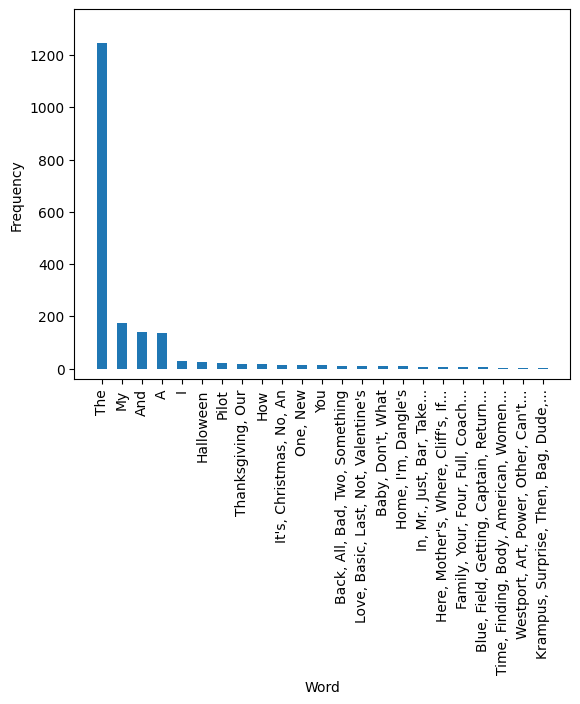

In [ ]:
import matplotlib.pyplot as plt

plt.bar(list(f2w.values()), list(f2w.keys()), width=.5)
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.ylim(-40,1375)
plt.show()